In [51]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db


In [52]:
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.labelsize'] = 16

In [53]:
# load opsim database
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases

# output directory
outDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir'
resultsDb = db.ResultsDb(outDir=outDir)



In [54]:
# get the name of all opsim dbs 
import glob

workpath = os.getcwd()
os.chdir(dbpath)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps/'
os.chdir(workpath) # change back to work directory
dblist_all.sort()



In [55]:
dblist_all[5:6]

['baseline_v1.5_10yrs.db']

In [56]:
def RADec2pix(nside, ra, dec, degree=True):
    """
    Calculate the nearest healpixel ID of an RA/Dec array, assuming nside.

    Parameters
    ----------
    nside : int
        The nside value of the healpix grid.
    ra : numpy.ndarray
        The RA values to be converted to healpix ids, in degree by default.
    dec : numpy.ndarray
        The Dec values to be converted to healpix ids, in degree by default.

    Returns
    -------
    numpy.ndarray
        The healpix ids.
    """
    if degree:
        ra = np.radians(ra) # change to radians
        dec = np.radians(dec)
    
    lat = np.pi/2. - dec
    hpid = hp.ang2pix(nside, lat, ra )
    return hpid

def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

In [58]:
from lsst.sims.maf.utils import m52snr

class filterPairTGapsMetric(metrics.BaseMetric):
    """
    returns
    N_v * np.exp(-Dkl) for each fields
    
    Parameters:
        colname: 
        fltpair: filter pair, eg ['r', 'i']
        snr_lim: list, signal to noise ratio (fiveSigmaDepth) threshold for fltpair, default [5, 5]
        filename: output a csv table for time gaps of each field
    
    """

    def __init__(self, colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], fltpair=['r', 'i'], tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
                 save_dT=False, filename=None, dataout=True, **kwargs):
        self.colname = colname
        self.filename = filename
        self.fltpair = fltpair
        self.mag_lim = mag_lim
        self.dataout = dataout
        self.tmin = tmin
        self.tmax = tmax
        self.bins = bins
        self.save_dT = save_dT
        
        self.Nrun = 0   # record the how many time run run()
        if filename!=None:
            if os.path.isfile(filename):
                # rm old file
                os.system("rm {}".format(filename))
                
        if self.dataout:
            super().__init__(col=self.colname, metricDtype='object', **kwargs)
        else:
            super().__init__(col=self.colname, metricDtype='float', **kwargs)
    
    def save_to_file(self, dic, filename="test_pkl.pkl"):
        '''save dict item to pickle file'''
        
        #df = self.load_from_pkl(filename)

        #df = df.append(pd.DataFrame(dic), ignore_index=True)

        #df.to_pickle(filename)
        df = pd.DataFrame(dic)
        with open(filename, 'a') as f:
            df.to_csv(f, header=f.tell()==0, index=None)
    
    def get_Dkl_i(self, values):
        '''kl divergence for histogram'''
        if values.any():
            values = values + 0.00001  # make each element non-zero
            prob = (values) / values.sum()  
        
            prob_uni = np.ones( len(prob) ) / len(prob)
            return np.sum( prob_uni * np.log(prob_uni / prob) )
        
        else:
            return np.NaN
        
    def get_FoM_i(self, dT_all, tmin=0, tmax=1.5/24, bins=50):
        """return FoM from array of metricValues"""
                
        dT_tlim = dT_all[(dT_all>tmin)&(dT_all<tmax)] 
        Nv = len(dT_tlim)
    
        values, bins_ = np.histogram(dT_tlim, bins=bins);
    
        Dkl = self.get_Dkl_i(values)
    
        FoM_i = Nv * np.exp(-Dkl)
        
        #print(self.Nrun, len(dT_all), Nv, Dkl, FoM_i)
        return Nv, Dkl, FoM_i, dT_tlim
      
    def run(self, dataSlice, slicePoint=None):
        
        # return all possible time gaps for each fields
        
        f0 = self.fltpair[0]
        f1 = self.fltpair[1]
        
        #check input config
        #print(f0, f1, self.tmin, self.tmax, self.mag_lim)
            
        # sort dataSlice
        
        idx0 = ( dataSlice['filter'] == f0 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[0])
        idx1 = ( dataSlice['filter'] == f1 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[1])
        
        timeCol0 = dataSlice['observationStartMJD'][idx0]
        timeCol1 = dataSlice['observationStartMJD'][idx1]

        timeCol0 = timeCol0.reshape((len(timeCol0), 1))
        timeCol1 = timeCol1.reshape((len(timeCol1), 1))
        
        #print( 'length of dataSlice', dataSlice.shape )
        # calculate time gaps matrix
        diffmat = np.abs( np.subtract(timeCol0, timeCol1.T) ) 
        
        # collect all time gaps
        if f0==f1:
            # get only triangle part
            dt_tri = np.tril(diffmat, -1)
            dT = dt_tri[dt_tri!=0]    # flatten lower triangle 
        else:
            dT = diffmat.flatten()

        Nv, Dkl, FoM_i, dT_tlim = self.get_FoM_i(dT, tmin=self.tmin, tmax=self.tmax, bins=self.bins)
        
        # print(self.Nrun, np.min(dataSlice['fiveSigmaDepth'][idx0]), np.min(dataSlice['fiveSigmaDepth'][idx1]),)
        self.Nrun += 1
        # write results to csv file
        fieldRA = np.mean(dataSlice['fieldRA']) ,
        fieldDec = np.mean(dataSlice['fieldDec']),
        
        if self.save_dT:
            dic = {'Nrun': self.Nrun, 
                'pixId': RADec2pix(nside=16, ra=fieldRA, dec=fieldDec)[0],
                'Nv': Nv,
                'Dkl': Dkl,
                'FoM_i': FoM_i,
                'dT_lim': dT_tlim
                  }
        else:
            dic = {'Nrun': self.Nrun, 
                'pixId': RADec2pix(nside=16, ra=fieldRA, dec=fieldDec)[0],
                'Nv': Nv,
                'Dkl': Dkl,
                'FoM_i': FoM_i,
                # 'dT_lim': dT_tlim
                  }
            
        if self.filename!=None:
            self.save_to_file(dic, filename=self.filename)
        
        if self.dataout:
            # return dT
            result = dic
            return result
        else:
        #    f0 = self.fltpair[0]
        #    f1 = self.fltpair[1]
            result = np.min(dT) if len(dT)!=0 else np.inf
            return float(result) 



In [59]:
def runMetric(dbname, fltpair, ipix_ms=None, nside=16, sqlstr=None,
              colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'],
              tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
              filename=None, dataout=True, **kwargs
             ):
    """run filterPairTGapsMetric
    dbname: name of opsim database
    fltpair: filter pair, eg: 'ri'
    ipix_ms: pixIds of footprint
    """
    opsdb = db.OpsimDatabase(dbpath+dbname)
    
    #fltpair = ['r', 'i']
    
    if ipix_ms!=None:
        # use UserPointsSlicer for minisurvey
        ra, dec = pix2radec(nside=nside, ipix=ipix_ms)
        slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
    else:
        # use HealpixSlicer 
        slicer = slicers.HealpixSlicer(nside=nside)
    
    # metric, slicer, constraint
    metric = filterPairTGapsMetric( colname=colname, fltpair=fltpair, tmin=tmin, tmax=tmax, bins=bins, mag_lim=mag_lim,
                 filename=filename, dataout=dataout, **kwargs)
    
    sqlconstraint = 'filter in ("{}", "{}")'.format(*fltpair)
    if sqlstr!=None:
        sqlconstraint += ' and {}'.format(sqlstr)
        
    # bundle
    newMetricSky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
    
    # group bundle
    bundleDict = {'newMetricSky':newMetricSky}
    group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)
    
    # run
    group.runAll()
    #group.plotAll(closefigs = False)
    return newMetricSky



In [60]:
ipix_LMC = [2899, 2900, 2901, 2934, 2935, 2936, 2965, 2966, 2967, 2992, 2993, 2994]
ipix_SMC = [2960, 2961, 2988, 2989, 3012]
ipix_GP = [ 144,  145,  146,  147,  179,  180,  181,  182,  183,  184,  217,
        218,  219,  225,  226,  260,  261,  271,  272,  307,  308,  320,
        321,  358,  374,  413,  431,  432,  471,  472,  493,  534,  535,
        558,  598,  599,  622,  661,  662,  687,  725,  726,  751,  788,
        789,  790,  815,  816,  852,  853,  854,  879,  915,  916,  917,
        944,  979,  980,  981, 1008, 1042, 1043, 1044, 1045, 1073, 1107,
       1108, 1109, 1136, 1170, 1171, 1172, 1201, 1234, 1235, 1236, 1237,
       1265, 1297, 1298, 1299, 1300, 1330, 1361, 1362, 1363, 1364, 1393,
       1425, 1426, 1427, 1428, 1458, 1489, 1490, 1491, 1492, 1522, 1552,
       1553, 1554, 1555, 1587, 1616, 1617, 1618, 1619, 1620, 1650, 1679,
       1680, 1681, 1682, 1683, 1715, 1744, 1745, 1746, 1747, 1779, 1807,
       1808, 1809, 1810, 1811, 1843, 1871, 1872, 1873, 1874, 1875, 1907,
       1934, 1935, 1936, 1937, 1938, 1972, 1998, 1999, 2000, 2001, 2002,
       2003, 2036, 2062, 2063, 2064, 2065, 2066, 2100, 2126, 2127, 2128,
       2129, 2130, 2164, 2189, 2190, 2191, 2192, 2193, 2194, 2229, 2253,
       2254, 2255, 2256, 2257, 2258, 2293, 2316, 2317, 2318, 2319, 2320,
       2321, 2358, 2380, 2381, 2382, 2383, 2384, 2385, 2421, 2422, 2443,
       2444, 2445, 2446, 2447, 2448, 2449, 2486, 2487, 2507, 2508, 2509,
       2510, 2511, 2512, 2513, 2550, 2551, 2570, 2571, 2572, 2573, 2574,
       2575, 2576, 2614, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2673,
       2687, 2688, 2689, 2690, 2691, 2692, 2693, 2728, 2729, 2739, 2740,
       2741, 2742, 2743, 2744, 2745, 2746, 2779, 2780, 2781, 2787, 2788,
       2789, 2790, 2791, 2792, 2793, 2794, 2826, 2827, 2828, 2829, 2830,
       2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2869, 2870,
       2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2908, 2909,
       2910, 2911, 2912, 2913, 2914, 2915, 2916, 2943, 2944, 2945, 2946,
       2947, 2948, 2974, 2975, 2976]


In [39]:
df = pd.read_csv('./data/Fields_nside16.csv')
# LMC, SMC
df['inLMC'] = np.isin(df['pixId'].values, ipix_LMC)
df['inSMC'] = np.isin(df['pixId'].values, ipix_SMC)
df['inGP'] = np.isin(df['pixId'].values, ipix_GP)

df.head()

,pixId,fieldRa,fieldDec,fieldGl,fieldGb,fieldEl,fieldEb,starDensity_r25,inLMC,inSMC,inGP
0,0,45.0,87.075820,124.642960,24.641921,85.217963,64.413844,0,False,False,False
1,1,135.0,87.075820,125.753479,28.655621,94.800547,64.412987,0,False,False,False
2,2,225.0,87.075820,121.143387,29.592908,95.668530,68.533082,0,False,False,False
3,3,315.0,87.075820,120.187742,25.546039,84.354664,68.534126,0,False,False,False
4,4,22.5,84.149733,123.982115,21.356778,77.697559,63.791264,0,False,False,False


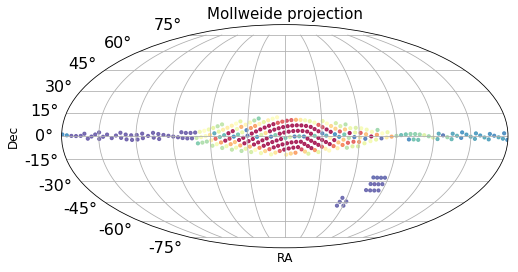

In [15]:
# plot footprint
fig, axs = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 


slicer = ( df['inLMC'] | df['inSMC'] | df['inGP'])
df_ = df[slicer]

#x = df_['fieldRa']
#y = df_['fieldDec']
x = df_['fieldGl']
y = df_['fieldGb']
#c = np.repeat(1.5, len(x))
c = df_['starDensity_r25']
plot_mwd(axs, RA=x, Dec=y, colorbar=False, c=c, s=10, alpha=0.8, vmax=1000000, cmap=plt.cm.Spectral_r)

axs.set_xticklabels([]);

### test run for one opsim

In [16]:
dblist_all[18]

'dcr_nham2_ugri_v1.5_10yrs.db'

In [37]:
ipix_ms = ipix_GP
#dbname = dblist_all[4] # baseline
#dbname = dblist_all[0]

dbname = 'third_obs_pt45v1.5_10yrs.db'
# run one filter pair for baseline
metricSky = runMetric( dbname=dbname, fltpair=['g', 'i'], 
              ipix_ms=ipix_ms, nside=16, sqlstr=None,
              colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'],
              tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
              filename=None, dataout=True, save_dT=True)


Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['fiveSigmaDepth', 'filter', 'fieldRA', 'observationStartMJD', 'fieldDec']
Found 719288 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [38]:
arr = metricSky.metricValues.data 
        
df = pd.DataFrame.from_records( arr[ arr != None ] )

In [39]:
df

,Dkl,FoM_i,Nrun,Nv,dT_lim,pixId
0,NaN,NaN,1,0,[],622
1,NaN,NaN,2,0,[],661
2,7.833782,0.000792,3,2,"[0.058358355876407586, 0.05794391539529897]",687
3,7.371144,0.000629,4,1,[0.06071237652213313],725
4,NaN,NaN,5,0,[],726
5,8.011193,0.001990,6,6,"[0.05629939065693179, 0.05670790503791068, 0.0...",751
6,8.225301,0.000803,7,3,"[0.014530358188494574, 0.013707963880733587, 0...",788
7,8.275543,0.001273,8,5,"[0.01618225729907863, 0.06111965853051515, 0.0...",789
8,7.371144,0.000629,9,1,[0.06030014438147191],790
9,8.008905,0.000997,10,3,"[0.03950954032188747, 0.04129989320063032, 0.0...",815


In [167]:
dbname

'filterdist_indx1_v1.5_10yrs.db'

In [175]:
data_df = get_cols(dbpath + dbname, cols='fieldRA, fieldDec, night, observationStartMJD, filter, fiveSigmaDepth')


connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/filterdist_indx1_v1.5_10yrs.db 
 SELECT fieldRA, fieldDec, night, observationStartMJD, filter, fiveSigmaDepth FROM SummaryAllProps


In [177]:
data_df['pixId'] = RADec2pix(nside=16, ra=data_df.fieldRA.values, dec=data_df.fieldDec.values )


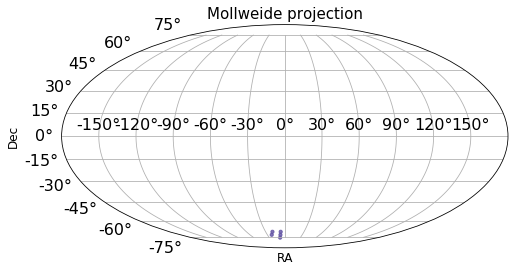

In [214]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 

ra, dec = pix2radec(nside=16, ipix=ipix_SMC)
x = ra
y = dec
c = np.repeat(1.5, len(x))

plot_mwd(ax=ax, RA=x, Dec=y, colorbar=False, c=c, s=10, alpha=0.8, vmax=1000000, cmap=plt.cm.Spectral_r)




### run time gaps metrics

In [61]:
def get_Dkl(values):
    '''kl divergence for histogram'''
    if values.any():
        values = values + 0.00001  # make each element non-zero
        prob = (values) / values.sum()  
    
        prob_uni = np.ones( len(prob) ) / len(prob)
        return np.sum( prob_uni * np.log(prob_uni / prob) )
    
    else:
        return np.NaN

def get_FoM_tgaps(df, tmin=0, tmax=1.5/24, bins=50):
    """return FoM from array of metricValues
    Inputs:
     df: pd.DataFrame, cols ['pixId', 'Dkl', 'FoM_i', 'Nv', 'dT_lim']
    """
    
    dT_all = np.concatenate(df.dT_lim.values)
    
    dT_tlim = dT_all[(dT_all>tmin)&(dT_all<tmax)] 
    Nv = len(dT_tlim)

    values, bins_ = np.histogram(dT_tlim, bins=bins);

    Dkl = get_Dkl(values)

    FoM = Nv * np.exp(-Dkl)
    
    return FoM


In [62]:
fltpairs = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy',
           'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy' ]

In [63]:
dblist_all[5:6 ]

['baseline_v1.5_10yrs.db']

In [78]:
%%time 
# run all filter pairs for baseline 

dicFoM = {}
dicFoM['db'] = dblist_all[5:6]

assert(dicFoM['db'] == ['baseline_v1.5_10yrs.db'] )

nside = 16
# select mini survey footprint 
ipix_ms = ipix_GP
msname = 'GP' # minisurvey label used to save files
#sqlstr = "night<4000 and proposalId=1"
#sqlstr = "proposalId=1"
sqlstr = None

magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

dataRaw = {}  # save the raw metricValues.data for each opsim each fltpair; dataRaw[fltpair][dbname]

for fltpair in fltpairs: 
    dicFoM[fltpair] = []
    dataRaw[fltpair] = {}
    for dbname in dicFoM['db']: 
        if fltpair[0]==fltpair[1]:
            tmin = 5/60/60/24 # in days
            tmax = 3e8/60./60./24    
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            tmin = 5/60/60/24
            tmax = 1.5/24 # 1.5 hour in days
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, save_dT=True, dataout=True );
            
        arr = metricSky.metricValues.data 
                
        df = pd.DataFrame.from_records( arr[ arr != None ] )
            
        FoM_tgaps = get_FoM_tgaps(df=df, tmin=tmin, tmax=tmax, bins=bins)

        dicFoM[fltpair].append(FoM_tgaps)
        
        dataRaw[fltpair][dbname] = pd.DataFrame.from_records( arr[ arr != None ] )[['pixId', 'Dkl', 'FoM_i', 'Nv']]  
        
        print('>>>', fltpair, dbname, FoM_tgaps)
        
    df_fom = pd.DataFrame(dicFoM)
    df_fom.to_csv('tgaps_FoM_baseline_v1.5_{}.csv'.format(msname), index=False)
    # save raw data to pickle
    pd.DataFrame( dataRaw ).to_pickle(outDir+'/tgaps_dataRaw_baseline_v1.5_{}.pkl'.format(msname),)



Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 141843 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu baseline_v1.5_10yrs.db 1417.0646372205845
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 365714 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ug baseline_v1.5_10yrs.db 1250.3091047932512
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 633519 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ur base

In [87]:
msname = 'GP'
df_dataRaw = pd.read_pickle( outDir+'/tgaps_dataRaw_baseline_v1.5_{}.pkl'.format(msname) )


In [84]:
df_dataRaw['rr']['baseline_v1.5_10yrs.db']

,pixId,Dkl,FoM_i,Nv
0,1393,7.883926,0.759530,2016
1,1428,9.122186,0.150499,1378
2,1458,6.738241,22.872379,19306
3,1489,6.639510,6.603722,5050
4,1492,6.876481,14.116661,13682
5,1522,6.795474,22.677506,20269
6,1552,6.461113,34.959304,22366
7,1555,7.920155,0.732506,2016
8,1587,6.522896,30.425539,20706
9,1616,5.981633,58.080704,23005


In [88]:
# get the median of N visits for each filter pair, 

Nvth = {}
for fltpair in fltpairs: 
    df = df_dataRaw[fltpair]['baseline_v1.5_10yrs.db']
    Nvth[fltpair] = np.median( df.Nv ) 
    

In [89]:
Nvth

{'uu': 780.0,
 'ug': 40.0,
 'ur': 25.0,
 'ui': 2.0,
 'uz': 0.0,
 'uy': 0.0,
 'gg': 1081.0,
 'gr': 39.0,
 'gi': 6.0,
 'gz': 0.0,
 'gy': 0.0,
 'rr': 1275.0,
 'ri': 33.0,
 'rz': 3.0,
 'ry': 0.0,
 'ii': 1176.0,
 'iz': 53.0,
 'iy': 8.0,
 'zz': 1126.0,
 'zy': 36.0,
 'yy': 1830.0}

In [90]:
starDens = np.load('../starDens16.npz')['starDens']


In [46]:
fltpairs[8:]

['gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

In [91]:
%%time 

# run for all opsims all filter pairs

dicFoMtGaps = {}
dicNfields = {}
dicNstar = {}

dbnames = dblist_all
dicFoMtGaps['db'] = dbnames
dicNfields['db'] = dbnames
dicNstar['db'] = dbnames

nside = 16

# select mini survey footprint 
ipix_ms = ipix_GP
msname = 'GP' # minisurvey label used to save files
#sqlstr = "night<4000 and proposalId=1"
#sqlstr = "proposalId=1"
sqlstr = None


magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

#--------------------------------
# empty metricArr 
diclist = []
for Nrun in range( len(ipix_ms) ):
    dic = {'Nrun': Nrun, 
                'pixId': ipix_ms[Nrun],
                'Nv': 0,
                'Dkl': 0,
                'FoM_i': 0,
                'dT_lim': []
                  }
    diclist.append(dic)
arr_empty = np.array(diclist)
df_empty = pd.DataFrame.from_records( arr_empty )
#--------------------------------

dataRaw = {}  # save the raw metricValues.data for each opsim each fltpair; dataRaw[fltpair][dbname]
#for fltpair in fltpairs[8:]:  
for fltpair in fltpairs:  
    dicFoMtGaps[fltpair] = []
    dicNfields[fltpair] = []
    dicNstar[fltpair] = []
    
    dataRaw[fltpair] = {}
    for dbname in dbnames: 

        print('running ', dbname, fltpair)
        if fltpair[0]==fltpair[1]:
            tmin = 5/60/60/24 # in days
            tmax = 3e8/60./60./24    
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            tmin = 5/60/60/24
            tmax = 1.5/24 # 1.5 hour in days
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, save_dT=True, dataout=True );
            
        arr = metricSky.metricValues.data 
        
        df = pd.DataFrame.from_records( arr[ arr != None ] )
        if len(df)==0:
            df = df_empty
        # count number of fields/stars above threshold 
        df['starDensity'] = starDens[ df['pixId'].values ] 
        idx = df['Nv'] > Nvth[fltpair]
        Nfields = df['Nv'][idx].shape[0]
        Nstar = np.sum( df['starDensity'][idx] )

        FoM_tgaps = get_FoM_tgaps(df=df, tmin=tmin, tmax=tmax, bins=bins)
                
        dicFoMtGaps[fltpair].append (FoM_tgaps)
        dicNfields[fltpair].append(Nfields)
        dicNstar[fltpair].append(Nstar)
        
        # save the raw data, 
        dataRaw[fltpair][dbname] = df[['pixId', 'Dkl', 'FoM_i', 'Nv']]  
        
        print('>>>', msname, fltpair, dbname, FoM_tgaps, Nfields, Nstar)
    
    df_fom = pd.DataFrame(dicFoMtGaps)
    df_fom.to_csv('df_tgapsFoM_{}.csv'.format(msname), index=False)
    
    df_fom = pd.DataFrame(dicNfields)
    df_fom.to_csv('df_Nfields_{}.csv'.format(msname), index=False)
    
    df_fom = pd.DataFrame(dicNstar)
    df_fom.to_csv('df_Nstar_{}.csv'.format(msname), index=False)
    
    # save raw data to pickle
    pd.DataFrame( dataRaw ).to_pickle(outDir+'/tgaps_dataRaw_{}.pkl'.format(msname),)



running  agnddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 156714 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu agnddf_v1.5_10yrs.db 1344.3176942223402 114 84720348
running  alt_dust_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 143535 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu alt_dust_v1.5_10yrs.db 1259.895408021927 49 32346396
running  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']


Found 347457 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu filterdist_indx1_v1.5_10yrs.db 4694.482152173998 195 218169900
running  filterdist_indx2_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 144750 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu filterdist_indx2_v1.5_10yrs.db 2405.3646876545545 186 213629040
running  filterdist_indx3_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 137608 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu filterdist_indx3_v1.5_10

Found 141448 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu goodseeing_gi_v1.5_10yrs.db 1383.6385910395936 114 76910904
running  goodseeing_gri_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 143123 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu goodseeing_gri_v1.5_10yrs.db 1871.5917682390814 117 84274452
running  goodseeing_griz_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 142206 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu goodseeing_griz_v1.5_10yrs.db 180

Found 141925 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu third_obs_pt30v1.5_10yrs.db 1770.5677252379649 122 85269024
running  third_obs_pt45v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 141536 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu third_obs_pt45v1.5_10yrs.db 1402.9546782957984 117 82355400
running  third_obs_pt60v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 141372 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu third_obs_pt60v1.5_10yrs.db 1777.0387

Found 142565 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu wfd_depth_scale0.90_noddf_v1.5_10yrs.db 2049.819476988055 123 84307716
running  wfd_depth_scale0.90_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 141634 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu wfd_depth_scale0.90_v1.5_10yrs.db 2113.320018263086 106 59311224
running  wfd_depth_scale0.95_noddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 140283 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu wfd

Found 369899 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug dcr_nham1_ugr_v1.5_10yrs.db 1166.6982850813963 66 64812672
running  dcr_nham1_ugri_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 370212 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug dcr_nham1_ugri_v1.5_10yrs.db 1129.1197901236862 68 68136156
running  dcr_nham2_ug_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 376006 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug dcr_nham2_ug_v1.5_10yrs.db 808.6946414

Found 362460 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug footprint_gp_smoothv1.5_10yrs.db 1382.9303794611917 162 174266676
running  footprint_newAv1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 378594 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug footprint_newAv1.5_10yrs.db 1042.3018149613024 76 92777292
running  footprint_newBv1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 382319 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug footprint_newBv1.5_10yrs.db 768.

Found 415534 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug short_exp_2ns_5expt_v1.5_10yrs.db 2091.8802954371145 219 233238024
running  short_exp_5ns_1expt_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 489836 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug short_exp_5ns_1expt_v1.5_10yrs.db 1653.0152350760814 227 237113028
running  short_exp_5ns_5expt_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 475777 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug short_exp_5

Found 377376 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug wfd_depth_scale0.75_noddf_v1.5_10yrs.db 1469.6780184236131 217 234499680
running  wfd_depth_scale0.75_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 377768 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug wfd_depth_scale0.75_v1.5_10yrs.db 1607.8260456477235 212 232136136
running  wfd_depth_scale0.80_noddf_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 373325 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug

Found 630375 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur bulges_cadence_bs_v1.5_10yrs.db 601.1678412953049 28 14719176
running  bulges_cadence_bulge_wfd_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 629551 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur bulges_cadence_bulge_wfd_v1.5_10yrs.db 916.7277686576217 50 79198200
running  bulges_cadence_i_heavy_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 627798 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur bulges

Found 633479 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur footprint_add_mag_cloudsv1.5_10yrs.db 1667.4364299754259 118 62617428
running  footprint_big_sky_dustv1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 631743 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur footprint_big_sky_dustv1.5_10yrs.db 219.24578474823122 25 13764168
running  footprint_big_sky_nouiyv1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 642111 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur foo

Found 634056 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur rolling_mod2_sdf_0.20_v1.5_10yrs.db 1784.5820585095141 116 73348560
running  rolling_mod3_sdf_0.10_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 631355 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur rolling_mod3_sdf_0.10_v1.5_10yrs.db 1664.9449452264664 112 61168032
running  rolling_mod3_sdf_0.20_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 632088 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur rolli

Found 555112 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur u60_v1.5_10yrs.db 838.4472000554862 26 8726220
running  var_expt_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 602163 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur var_expt_v1.5_10yrs.db 2576.129771919037 137 121036464
running  wfd_depth_scale0.65_noddf_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 648086 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur wfd_depth_scale0.65_noddf_v1.5_10yrs.db 2738.626

Found 638894 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db 132.82014955533867 51 43213680
running  baseline_2snaps_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 589019 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui baseline_2snaps_v1.5_10yrs.db 408.4767070374021 113 85892220
running  baseline_samefilt_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 677417 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui baseline_samefilt

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui filterdist_indx3_v1.5_10yrs.db 3.745864310019626 36 31033440
running  filterdist_indx4_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 784526 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui filterdist_indx4_v1.5_10yrs.db 365.6119387932739 110 136773936
running  filterdist_indx5_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 509645 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui filterdist_indx5_v1.5_10yrs.db 525.3143496820478 157 176576112
running  fi

Found 636310 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui goodseeing_griz_v1.5_10yrs.db 474.73729643083107 133 104470704
running  goodseeing_gz_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 636660 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui goodseeing_gz_v1.5_10yrs.db 383.95374285319747 135 118279836
running  goodseeing_i_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 639451 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui goodseeing_i_v1.5_10yrs.db 433.778

Found 637866 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui third_obs_pt60v1.5_10yrs.db 471.3419864721651 130 125889156
running  third_obs_pt90v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 640119 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui third_obs_pt90v1.5_10yrs.db 402.9131175199778 115 94161996
running  twilight_neo_mod1_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 913130 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui twilight_neo_mod1_v1.5_10yrs.db 47

Found 634400 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui wfd_depth_scale0.95_noddf_v1.5_10yrs.db 308.1719842970885 98 52607988
running  wfd_depth_scale0.95_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 634174 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui wfd_depth_scale0.95_v1.5_10yrs.db 394.30369828632683 94 49623480
running  wfd_depth_scale0.99_noddf_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 630397 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui wfd_

Found 580057 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz dcr_nham2_ugr_v1.5_10yrs.db nan 0 0
running  dcr_nham2_ugri_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 577864 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz dcr_nham2_ugri_v1.5_10yrs.db nan 0 0
running  descddf_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 595780 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz descddf_v1.5_10yrs.db nan 0 0
running  filterdist_indx1_v1.5_10yrs.db uz
Querying databas

Found 574421 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz footprint_standard_goalsv1.5_10yrs.db nan 0 0
running  footprint_stuck_rollingv1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 573123 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz footprint_stuck_rollingv1.5_10yrs.db nan 0 0
running  goodseeing_gi_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 572804 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz goodseeing_gi_v1.5_10yrs.db nan 0 0
running  goodseeing_g

Found 574965 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz third_obs_pt15v1.5_10yrs.db nan 0 0
running  third_obs_pt30v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 575365 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz third_obs_pt30v1.5_10yrs.db nan 0 0
running  third_obs_pt45v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 575201 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz third_obs_pt45v1.5_10yrs.db nan 0 0
running  third_obs_pt60v1.5_10yrs.db uz
Querying 

Found 583996 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz wfd_depth_scale0.90_noddf_v1.5_10yrs.db nan 0 0
running  wfd_depth_scale0.90_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 574562 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz wfd_depth_scale0.90_v1.5_10yrs.db nan 0 0
running  wfd_depth_scale0.95_noddf_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 579157 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz wfd_depth_scale0.95_noddf_v1.5_10yrs.db nan 0 0
r

Found 582147 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy dcr_nham1_ugri_v1.5_10yrs.db nan 0 0
running  dcr_nham2_ug_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 587129 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy dcr_nham2_ug_v1.5_10yrs.db nan 0 0
running  dcr_nham2_ugr_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 585145 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy dcr_nham2_ugr_v1.5_10yrs.db nan 0 0
running  dcr_nham2_ugri_v1.5_10yrs.db uy
Querying 

Found 613707 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy footprint_newBv1.5_10yrs.db nan 0 0
running  footprint_no_gp_northv1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 579469 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy footprint_no_gp_northv1.5_10yrs.db nan 0 0
running  footprint_standard_goalsv1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 580475 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy footprint_standard_goalsv1.5_10yrs.db nan 0 0
running  footpr

Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 581168 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy spiders_v1.5_10yrs.db nan 0 0
running  third_obs_pt120v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 582632 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy third_obs_pt120v1.5_10yrs.db nan 0 0
running  third_obs_pt15v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 579584 visits
Running:  ['newMetricSky']
Completed metric generation.
Runn

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy wfd_depth_scale0.80_v1.5_10yrs.db nan 0 0
running  wfd_depth_scale0.85_noddf_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 565570 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy wfd_depth_scale0.85_noddf_v1.5_10yrs.db nan 0 0
running  wfd_depth_scale0.85_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 570424 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy wfd_depth_scale0.85_v1.5_10yrs.db nan 0 0
running  wfd_depth_scale0.90_noddf_v1.5_10yrs.db uy
Qu

Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 217764 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg daily_ddf_v1.5_10yrs.db 2750.00567778476 109 56064708
running  dcr_nham1_ug_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 224646 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg dcr_nham1_ug_v1.5_10yrs.db 4050.9183356777253 111 72522720
running  dcr_nham1_ugr_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 224085 visits
Running:  ['newM

Found 218481 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg footprint_big_wfdv1.5_10yrs.db 2507.8954195029096 110 52598196
running  footprint_bluer_footprintv1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 400012 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg footprint_bluer_footprintv1.5_10yrs.db 7570.607086802114 104 55808388
running  footprint_gp_smoothv1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 221626 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg footprin

Found 228130 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg rolling_mod6_sdf_0.20_v1.5_10yrs.db 3497.7286347320473 96 45003060
running  short_exp_2ns_1expt_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 256420 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg short_exp_2ns_1expt_v1.5_10yrs.db 5337.821735663963 186 140255604
running  short_exp_2ns_5expt_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 251920 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg short_exp_2n

Found 236857 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg wfd_depth_scale0.70_noddf_v1.5_10yrs.db 5710.64321231322 243 239427792
running  wfd_depth_scale0.70_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 237503 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg wfd_depth_scale0.70_v1.5_10yrs.db 5152.67940795653 244 239864148
running  wfd_depth_scale0.75_noddf_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 233271 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg wfd

Found 717293 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr bulges_bs_v1.5_10yrs.db 1258.0902455946011 68 32398308
running  bulges_bulge_wfd_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 716565 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr bulges_bulge_wfd_v1.5_10yrs.db 1586.2268068550823 100 101251080
running  bulges_cadence_bs_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 717074 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr bulges_cadence_bs_v1.5_10yrs.db

Found 721523 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr filterdist_indx7_v1.5_10yrs.db 4986.280436039736 192 217204668
running  filterdist_indx8_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 628515 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr filterdist_indx8_v1.5_10yrs.db 3595.526259193679 186 213957072
running  footprint_add_mag_cloudsv1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 715106 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr footprint_add_mag_

Found 717158 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr roll_mod2_dust_sdf_0.20_v1.5_10yrs.db 1289.5898021507894 63 31852908
running  rolling_mod2_sdf_0.10_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 718187 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr rolling_mod2_sdf_0.10_v1.5_10yrs.db 2381.2957754391787 118 55769004
running  rolling_mod2_sdf_0.20_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 717807 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr roll

Found 817650 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr twilight_neo_mod3_v1.5_10yrs.db 2008.0102450299962 99 41741316
running  twilight_neo_mod4_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 791399 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr twilight_neo_mod4_v1.5_10yrs.db 2100.562774510839 108 45684504
running  u60_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 689946 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr u60_v1.5_10yrs.db 2084.0070474473405 

running  agnddf_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 694317 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi agnddf_v1.5_10yrs.db 246.60048108481087 110 69291216
running  alt_dust_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 725745 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi alt_dust_v1.5_10yrs.db 112.72453680779374 40 27274752
running  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']

Found 737745 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi filterdist_indx1_v1.5_10yrs.db 735.9993239155548 181 211898484
running  filterdist_indx2_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 699457 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi filterdist_indx2_v1.5_10yrs.db 1363.6010260718647 189 215459640
running  filterdist_indx3_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 845727 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi filterdist_indx3_v1.5_10

Found 721631 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi goodseeing_gi_v1.5_10yrs.db 277.11317387289125 108 73328616
running  goodseeing_gri_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 720479 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi goodseeing_gri_v1.5_10yrs.db 379.92435629726566 110 76285872
running  goodseeing_griz_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 717653 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi goodseeing_griz_v1.5_10yrs.db 310

Found 719189 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi third_obs_pt30v1.5_10yrs.db 196.16357475642826 123 108626724
running  third_obs_pt45v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 719288 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi third_obs_pt45v1.5_10yrs.db 418.25563919765017 114 94737744
running  third_obs_pt60v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 721008 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi third_obs_pt60v1.5_10yrs.db 287.1020

Found 716388 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi wfd_depth_scale0.90_noddf_v1.5_10yrs.db 257.3208250289677 116 87069204
running  wfd_depth_scale0.90_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 719342 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi wfd_depth_scale0.90_v1.5_10yrs.db 319.0314033770657 142 117777420
running  wfd_depth_scale0.95_noddf_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 712505 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi wf

Found 655458 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz dcr_nham1_ugr_v1.5_10yrs.db 12.356877767757036 74 52719696
running  dcr_nham1_ugri_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 655754 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz dcr_nham1_ugri_v1.5_10yrs.db 13.43083713030901 68 72787284
running  dcr_nham2_ug_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 654776 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz dcr_nham2_ug_v1.5_10yrs.db 16.508356223

Found 654232 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz footprint_gp_smoothv1.5_10yrs.db 19.795498984211534 111 151472376
running  footprint_newAv1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 633323 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz footprint_newAv1.5_10yrs.db 1.0119331770634263 42 54968616
running  footprint_newBv1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 635295 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz footprint_newBv1.5_10yrs.db 0.23

Found 738076 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz short_exp_2ns_5expt_v1.5_10yrs.db 0.8956508268579507 33 13385232
running  short_exp_5ns_1expt_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 858209 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz short_exp_5ns_1expt_v1.5_10yrs.db 0.24189448081434783 43 20877192
running  short_exp_5ns_5expt_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 833617 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz short_exp_5ns_

Found 682751 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz wfd_depth_scale0.75_noddf_v1.5_10yrs.db 13.25627544250986 71 49164516
running  wfd_depth_scale0.75_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 674872 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz wfd_depth_scale0.75_v1.5_10yrs.db 1.4326119121911844 61 52600860
running  wfd_depth_scale0.80_noddf_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 676669 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz wfd_

Found 667891 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy bulges_cadence_bs_v1.5_10yrs.db 0.03981759960761974 15 12160980
running  bulges_cadence_bulge_wfd_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 668506 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy bulges_cadence_bulge_wfd_v1.5_10yrs.db 0.024141899321990012 16 23636412
running  bulges_cadence_i_heavy_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 664135 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy b

Found 662003 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy footprint_add_mag_cloudsv1.5_10yrs.db 0.04564924722118578 34 42097644
running  footprint_big_sky_dustv1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 682078 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy footprint_big_sky_dustv1.5_10yrs.db 0.010690561290311488 11 5375592
running  footprint_big_sky_nouiyv1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 672277 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy fo

Found 668801 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy rolling_mod2_sdf_0.20_v1.5_10yrs.db 0.08919863126802041 30 24788160
running  rolling_mod3_sdf_0.10_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 672208 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy rolling_mod3_sdf_0.10_v1.5_10yrs.db 0.0936135889966144 33 24758388
running  rolling_mod3_sdf_0.20_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 672343 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy rollin

Found 639450 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy u60_v1.5_10yrs.db 0.30541298955247675 34 20641644
running  var_expt_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 625185 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy var_expt_v1.5_10yrs.db 0.08057466240451516 24 18676944
running  wfd_depth_scale0.65_noddf_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 618267 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy wfd_depth_scale0.65_noddf_v1.5_10yrs.db 0.003

Found 483487 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db 2511.5295369373994 245 239892012
running  baseline_2snaps_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 454045 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr baseline_2snaps_v1.5_10yrs.db 6534.933550733695 115 55232712
running  baseline_samefilt_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 506454 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr baseline_samefi

Found 441198 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr filterdist_indx3_v1.5_10yrs.db 6807.095818798587 195 218169900
running  filterdist_indx4_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 435207 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr filterdist_indx4_v1.5_10yrs.db 7891.46072420459 195 218169900
running  filterdist_indx5_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 386481 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr filterdist_indx5_v1.5_10yr

Found 491307 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr goodseeing_griz_v1.5_10yrs.db 5799.52474117902 118 58525020
running  goodseeing_gz_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 491308 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr goodseeing_gz_v1.5_10yrs.db 7651.116330700068 122 66793644
running  goodseeing_i_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 491458 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr goodseeing_i_v1.5_10yrs.db 7630.0963500

Found 493053 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr third_obs_pt60v1.5_10yrs.db 8248.232117514199 124 69789060
running  third_obs_pt90v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 494157 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr third_obs_pt90v1.5_10yrs.db 8807.044789378937 120 65020644
running  twilight_neo_mod1_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 765694 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr twilight_neo_mod1_v1.5_10yrs.db 172

Found 489513 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr wfd_depth_scale0.95_noddf_v1.5_10yrs.db 6283.711436449956 101 47645532
running  wfd_depth_scale0.95_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 490264 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr wfd_depth_scale0.95_v1.5_10yrs.db 7149.644494285141 99 45586296
running  wfd_depth_scale0.99_noddf_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 488951 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr wfd_

Found 981680 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri dcr_nham2_ug_v1.5_10yrs.db 2593.179530004527 127 91428444
running  dcr_nham2_ugr_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 983689 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri dcr_nham2_ugr_v1.5_10yrs.db 2330.8349618146744 114 65650176
running  dcr_nham2_ugri_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 987527 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri dcr_nham2_ugri_v1.5_10yrs.db 2035.1316

Found 982935 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri footprint_newBv1.5_10yrs.db 3171.096934858544 195 224301024
running  footprint_no_gp_northv1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 988302 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri footprint_no_gp_northv1.5_10yrs.db 2186.194940803364 122 85633668
running  footprint_standard_goalsv1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 987228 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri footprint_stan

Found 1249000 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri short_exp_5ns_5expt_v1.5_10yrs.db 4837.394143583159 191 173296296
running  spiders_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 988951 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri spiders_v1.5_10yrs.db 2382.816891542819 112 60439428
running  third_obs_pt120v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 995023 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri third_obs_pt120v1.5_10yrs.db 3160.80134016

Found 996462 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri wfd_depth_scale0.80_noddf_v1.5_10yrs.db 2858.56020447037 171 149567328
running  wfd_depth_scale0.80_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 997821 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri wfd_depth_scale0.80_v1.5_10yrs.db 2684.47854105199 172 145705788
running  wfd_depth_scale0.85_noddf_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 992679 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri wfd

Found 919548 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz bulges_cadence_i_heavy_v1.5_10yrs.db 47.63898262962753 69 100365984
running  bulges_i_heavy_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 919157 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz bulges_i_heavy_v1.5_10yrs.db 78.32749574048314 79 121622112
running  daily_ddf_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 882602 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz daily_ddf_v1.5_10yrs.db 267.6549

Found 953956 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz footprint_big_sky_nouiyv1.5_10yrs.db 0.004271415455332663 0 0
running  footprint_big_skyv1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 938271 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz footprint_big_skyv1.5_10yrs.db 0.7327139533805325 10 1996056
running  footprint_big_wfdv1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 911664 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz footprint_big_wfdv1.5_10yrs.

Found 921300 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz rolling_mod3_sdf_0.20_v1.5_10yrs.db 403.4092554468517 125 85880160
running  rolling_mod6_sdf_0.10_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 920786 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz rolling_mod6_sdf_0.10_v1.5_10yrs.db 996.8216091880965 115 79095780
running  rolling_mod6_sdf_0.20_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 918229 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz rolling

Found 956697 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz wfd_depth_scale0.65_noddf_v1.5_10yrs.db 854.0250001319038 161 165611772
running  wfd_depth_scale0.65_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 947868 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz wfd_depth_scale0.65_v1.5_10yrs.db 265.37661878561323 154 145834308
running  wfd_depth_scale0.70_noddf_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 953055 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz 

Found 944200 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry baseline_samefilt_v1.5_10yrs.db 7.4237810151406185 27 12833460
running  baseline_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 929417 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry baseline_v1.5_10yrs.db 3.8024426965571054 49 37334556
running  bulges_bs_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 929847 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry bulges_bs_v1.5_10yrs.db 1.7886582893450056 44 534

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry filterdist_indx5_v1.5_10yrs.db 89.9224697516381 101 99319932
running  filterdist_indx6_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 854367 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry filterdist_indx6_v1.5_10yrs.db 1.7976925427345065 39 54585036
running  filterdist_indx7_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 879803 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry filterdist_indx7_v1.5_10yrs.db 74.09580054132176 70 77480856
running  filte

Found 928301 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry goodseeing_i_v1.5_10yrs.db 5.236927158807411 49 33291936
running  greedy_footprint_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 928687 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry greedy_footprint_v1.5_10yrs.db 17.849486451060063 55 29916540
running  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 927230 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry roll_mod2_dust_sdf_0.20_v

Found 1327470 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry twilight_neo_mod1_v1.5_10yrs.db 60.25488127993192 54 31795992
running  twilight_neo_mod2_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 1133485 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry twilight_neo_mod2_v1.5_10yrs.db 4.4038976469369 48 33013260
running  twilight_neo_mod3_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 1064597 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry twilight_neo_mod3_v1.5_1

Found 943526 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry wfd_depth_scale0.99_noddf_v1.5_10yrs.db 34.217453590655275 47 22430124
running  wfd_depth_scale0.99_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 947834 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry wfd_depth_scale0.99_v1.5_10yrs.db 0.6768005037616499 38 18025308
running  agnddf_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 479966 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii agnddf_v1.5_10yrs.db 4

Found 497052 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii dcr_nham2_ugri_v1.5_10yrs.db 10252.825933558413 126 85476780
running  descddf_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 487189 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii descddf_v1.5_10yrs.db 6382.26991104657 123 64423080
running  filterdist_indx1_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 370812 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii filterdist_indx1_v1.5_10yrs.db 6677.62098077677

Found 495471 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii footprint_standard_goalsv1.5_10yrs.db 6592.927163446224 129 73177812
running  footprint_stuck_rollingv1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 500134 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii footprint_stuck_rollingv1.5_10yrs.db 7724.7355314031265 63 25764624
running  goodseeing_gi_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 497101 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii goodseeing_

Found 499845 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii third_obs_pt120v1.5_10yrs.db 12714.524773465802 126 68614884
running  third_obs_pt15v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 495842 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii third_obs_pt15v1.5_10yrs.db 7001.64217069084 125 76289184
running  third_obs_pt30v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 495581 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii third_obs_pt30v1.5_10yrs.db 6896.40004

Found 497885 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii wfd_depth_scale0.85_noddf_v1.5_10yrs.db 6908.751483278094 203 185836392
running  wfd_depth_scale0.85_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 498292 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii wfd_depth_scale0.85_v1.5_10yrs.db 6922.908475310814 205 195877548
running  wfd_depth_scale0.90_noddf_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 493995 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii w

Found 896859 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz daily_ddf_v1.5_10yrs.db 2839.3635259089397 119 76914900
running  dcr_nham1_ug_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 925200 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz dcr_nham1_ug_v1.5_10yrs.db 2668.6154466997214 128 74525976
running  dcr_nham1_ugr_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 924354 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz dcr_nham1_ugr_v1.5_10yrs.db 2726.7155817209

Found 914848 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz footprint_big_wfdv1.5_10yrs.db 2647.490561109449 132 74461896
running  footprint_bluer_footprintv1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 835954 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz footprint_bluer_footprintv1.5_10yrs.db 2816.0939655052002 123 68623848
running  footprint_gp_smoothv1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 928992 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz footprin

Found 925581 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz rolling_mod6_sdf_0.20_v1.5_10yrs.db 3200.2600591035225 115 54140724
running  short_exp_2ns_1expt_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 1058393 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz short_exp_2ns_1expt_v1.5_10yrs.db 4473.015180831029 234 224646084
running  short_exp_2ns_5expt_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 1043127 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz short_exp

Found 957387 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz wfd_depth_scale0.70_noddf_v1.5_10yrs.db 3692.420509700029 233 227179008
running  wfd_depth_scale0.70_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 947146 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz wfd_depth_scale0.70_v1.5_10yrs.db 3298.846168361387 227 223963776
running  wfd_depth_scale0.75_noddf_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 951969 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz w

Found 937835 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy bulges_bs_v1.5_10yrs.db 726.0898573300076 88 118370844
running  bulges_bulge_wfd_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 938058 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy bulges_bulge_wfd_v1.5_10yrs.db 923.8718794458433 91 118990440
running  bulges_cadence_bs_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 938021 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy bulges_cadence_bs_v1.5_10yrs.db 7

Found 879915 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy filterdist_indx7_v1.5_10yrs.db 2671.796125727974 192 216616212
running  filterdist_indx8_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 984989 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy filterdist_indx8_v1.5_10yrs.db 2714.9812438381964 190 216504900
running  footprint_add_mag_cloudsv1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 934500 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy footprint_add_mag

Found 935428 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy roll_mod2_dust_sdf_0.20_v1.5_10yrs.db 760.068836212583 63 96632064
running  rolling_mod2_sdf_0.10_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 934001 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy rolling_mod2_sdf_0.10_v1.5_10yrs.db 1448.1352979287328 118 80957988
running  rolling_mod2_sdf_0.20_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 933453 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy rollin

Found 1066361 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy twilight_neo_mod3_v1.5_10yrs.db 1236.336298485427 104 47895012
running  twilight_neo_mod4_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 1031315 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy twilight_neo_mod4_v1.5_10yrs.db 1138.3296989837993 91 43513488
running  u60_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 904576 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy u60_v1.5_10yrs.db 1465.568005476685

running  agnddf_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 435884 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz agnddf_v1.5_10yrs.db 6844.16171417825 125 64337688
running  alt_dust_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 434991 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz alt_dust_v1.5_10yrs.db 3524.9978571341167 243 236384892
running  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']

Found 375478 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz filterdist_indx1_v1.5_10yrs.db 12644.719730291863 195 218169900
running  filterdist_indx2_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 437267 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz filterdist_indx2_v1.5_10yrs.db 12230.593286988158 195 218169900
running  filterdist_indx3_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 391678 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz filterdist_indx3_v1.5_1

Found 431356 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz goodseeing_gi_v1.5_10yrs.db 7393.855746584661 123 67100796
running  goodseeing_gri_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 431364 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz goodseeing_gri_v1.5_10yrs.db 5303.299601611452 128 78070176
running  goodseeing_griz_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 432894 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz goodseeing_griz_v1.5_10yrs.db 6865.

Found 433440 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz third_obs_pt30v1.5_10yrs.db 7369.380380952399 123 71123904
running  third_obs_pt45v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 433665 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz third_obs_pt45v1.5_10yrs.db 5616.508109628922 129 78954444
running  third_obs_pt60v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 433610 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz third_obs_pt60v1.5_10yrs.db 5710.283764

Found 441431 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz wfd_depth_scale0.90_noddf_v1.5_10yrs.db 7316.958649525769 133 83133936
running  wfd_depth_scale0.90_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 432928 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz wfd_depth_scale0.90_v1.5_10yrs.db 3906.1306119047626 125 73037988
running  wfd_depth_scale0.95_noddf_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 438874 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz wf

Found 867749 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy dcr_nham1_ugr_v1.5_10yrs.db 3249.8571245745266 106 73258056
running  dcr_nham1_ugri_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 867689 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy dcr_nham1_ugri_v1.5_10yrs.db 3473.8440178755877 122 92737116
running  dcr_nham2_ug_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 865899 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy dcr_nham2_ug_v1.5_10yrs.db 3620.3864

Found 872082 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy footprint_gp_smoothv1.5_10yrs.db 7083.387866548438 231 237952584
running  footprint_newAv1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 864347 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy footprint_newAv1.5_10yrs.db 4626.2270560905245 220 231662376
running  footprint_newBv1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 866683 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy footprint_newBv1.5_10yrs.db 377

Found 974868 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy short_exp_2ns_5expt_v1.5_10yrs.db 4298.25750469764 152 168995088
running  short_exp_5ns_1expt_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 1128194 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy short_exp_5ns_1expt_v1.5_10yrs.db 5539.887348491781 196 208574748
running  short_exp_5ns_5expt_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 1096444 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy short_exp_5n

Found 847660 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy wfd_depth_scale0.75_noddf_v1.5_10yrs.db 3982.31048352113 200 182653164
running  wfd_depth_scale0.75_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 845242 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy wfd_depth_scale0.75_v1.5_10yrs.db 3622.940163170157 198 187228584
running  wfd_depth_scale0.80_noddf_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 856831 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy wf

Found 440824 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy bulges_cadence_bs_v1.5_10yrs.db 3437.000592626317 129 129792960
running  bulges_cadence_bulge_wfd_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 440907 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy bulges_cadence_bulge_wfd_v1.5_10yrs.db 6395.359690688995 142 147124584
running  bulges_cadence_i_heavy_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 437942 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy bu

Found 439046 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy footprint_add_mag_cloudsv1.5_10yrs.db 6303.166336054034 107 67855896
running  footprint_big_sky_dustv1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 467225 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy footprint_big_sky_dustv1.5_10yrs.db 1160.9917823834417 47 23209704
running  footprint_big_sky_nouiyv1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 441250 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy foot

Found 439435 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy rolling_mod2_sdf_0.20_v1.5_10yrs.db 6647.069984462442 142 102463272
running  rolling_mod3_sdf_0.10_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 443981 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy rolling_mod3_sdf_0.10_v1.5_10yrs.db 7336.351221983905 114 79005780
running  rolling_mod3_sdf_0.20_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 442903 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy rollin

Found 425407 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy u60_v1.5_10yrs.db 6057.763833353642 115 77996412
running  var_expt_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 410855 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy var_expt_v1.5_10yrs.db 8551.398503850887 97 47713176
running  wfd_depth_scale0.65_noddf_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 377932 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy wfd_depth_scale0.65_noddf_v1.5_10yrs.db 6514.098

In [295]:
len( dicFoMtGaps['ug'] )

85

In [289]:
dicNfields

{'db': ['agnddf_v1.5_10yrs.db',
  'alt_dust_v1.5_10yrs.db',
  'alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db',
  'baseline_2snaps_v1.5_10yrs.db',
  'baseline_v1.5_10yrs.db',
  'bulges_bs_v1.5_10yrs.db',
  'bulges_bulge_wfd_v1.5_10yrs.db',
  'bulges_cadence_bs_v1.5_10yrs.db',
  'bulges_cadence_bulge_wfd_v1.5_10yrs.db',
  'bulges_cadence_i_heavy_v1.5_10yrs.db',
  'bulges_i_heavy_v1.5_10yrs.db',
  'daily_ddf_v1.5_10yrs.db',
  'dcr_nham1_ug_v1.5_10yrs.db',
  'dcr_nham1_ugr_v1.5_10yrs.db',
  'dcr_nham1_ugri_v1.5_10yrs.db',
  'dcr_nham2_ug_v1.5_10yrs.db',
  'dcr_nham2_ugr_v1.5_10yrs.db',
  'dcr_nham2_ugri_v1.5_10yrs.db',
  'descddf_v1.5_10yrs.db',
  'filterdist_indx1_v1.5_10yrs.db',
  'filterdist_indx2_v1.5_10yrs.db',
  'filterdist_indx3_v1.5_10yrs.db',
  'filterdist_indx4_v1.5_10yrs.db',
  'filterdist_indx5_v1.5_10yrs.db',
  'filterdist_indx6_v1.5_10yrs.db',
  'filterdist_indx7_v1.5_10yrs.db',
  'filterdist_indx8_v1.5_10yrs.db',
  'footprint_add_mag_cloudsv1.5_10yrs.db',
  'footprint_big_sky_du

In [283]:
fltpairs

['uu',
 'ug',
 'ur',
 'ui',
 'uz',
 'uy',
 'gg',
 'gr',
 'gi',
 'gz',
 'gy',
 'rr',
 'ri',
 'rz',
 'ry',
 'ii',
 'iz',
 'iy',
 'zz',
 'zy',
 'yy']

In [282]:
arr

array([{'Nrun': 1, 'pixId': 2960, 'Nv': 16, 'Dkl': 9.389035094784543, 'FoM_i': 0.0013381778918751632, 'dT_lim': array([0.03486494, 0.01622914, 0.01663874, 0.03445455, 0.01581876,
       0.01622835, 0.016427  , 0.01637211, 0.01577378, 0.01580907,
       0.01580081, 0.01579388, 0.01629143, 0.01587913, 0.01670415,
       0.01629185])},
       {'Nrun': 2, 'pixId': 2961, 'Nv': 14, 'Dkl': 9.259228921712946, 'FoM_i': 0.0013332021590298263, 'dT_lim': array([0.01629517, 0.01547095, 0.01577593, 0.0162343 , 0.01584717,
       0.04710375, 0.01584275, 0.03891336, 0.01580825, 0.01580039,
       0.01712061, 0.01629639, 0.01578351, 0.01666315])},
       {'Nrun': 3, 'pixId': 2988, 'Nv': 6, 'Dkl': 9.141422083075629, 'FoM_i': 0.0006428091986966666, 'dT_lim': array([0.01629154, 0.01579341, 0.01584644, 0.01577392, 0.01642766,
       0.01580075])},
       {'Nrun': 4, 'pixId': 2989, 'Nv': 9, 'Dkl': 8.84198637092099, 'FoM_i': 0.0013008182446101583, 'dT_lim': array([0.01666357, 0.01580157, 0.0380909 , 0.015842

In [278]:
dicNfields['uu']

[1, 3, 0]

In [122]:
df

""


In [121]:
dblist_all

['agnddf_v1.5_10yrs.db',
 'alt_dust_v1.5_10yrs.db',
 'alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db',
 'baseline_2snaps_v1.5_10yrs.db',
 'baseline_v1.5_10yrs.db',
 'bulges_bs_v1.5_10yrs.db',
 'bulges_bulge_wfd_v1.5_10yrs.db',
 'bulges_cadence_bs_v1.5_10yrs.db',
 'bulges_cadence_bulge_wfd_v1.5_10yrs.db',
 'bulges_cadence_i_heavy_v1.5_10yrs.db',
 'bulges_i_heavy_v1.5_10yrs.db',
 'daily_ddf_v1.5_10yrs.db',
 'dcr_nham1_ug_v1.5_10yrs.db',
 'dcr_nham1_ugr_v1.5_10yrs.db',
 'dcr_nham1_ugri_v1.5_10yrs.db',
 'dcr_nham2_ug_v1.5_10yrs.db',
 'dcr_nham2_ugr_v1.5_10yrs.db',
 'dcr_nham2_ugri_v1.5_10yrs.db',
 'descddf_v1.5_10yrs.db',
 'filterdist_indx1_v1.5_10yrs.db',
 'filterdist_indx2_v1.5_10yrs.db',
 'filterdist_indx3_v1.5_10yrs.db',
 'filterdist_indx4_v1.5_10yrs.db',
 'filterdist_indx5_v1.5_10yrs.db',
 'filterdist_indx6_v1.5_10yrs.db',
 'filterdist_indx7_v1.5_10yrs.db',
 'filterdist_indx8_v1.5_10yrs.db',
 'footprint_add_mag_cloudsv1.5_10yrs.db',
 'footprint_big_sky_dustv1.5_10yrs.db',
 'footprint_big_s

In [268]:
dataRaw

{'uu': {'dcr_nham2_ugri_v1.5_10yrs.db':    pixId       Dkl     FoM_i   Nv
  0   2960  8.441504  0.121022  561
  1   2961  7.956633  0.184975  528
  2   2988  8.771589  0.103281  666
  3   2989  8.167952  0.159099  561
  4   3012  7.952372  0.197375  561,
  'descddf_v1.5_10yrs.db':    pixId       Dkl     FoM_i   Nv
  0   2960  8.702763  0.098845  595
  1   2961  8.340162  0.118412  496
  2   2988  8.886447  0.052258  378
  3   2989  8.231738  0.167626  630
  4   3012  7.913657  0.285258  780,
  'filterdist_indx1_v1.5_10yrs.db':    pixId  Dkl  FoM_i  Nv
  0   2960    0      0   0
  1   2961    0      0   0
  2   2988    0      0   0
  3   2989    0      0   0
  4   3012    0      0   0},
 'ug': {'dcr_nham2_ugri_v1.5_10yrs.db':    pixId        Dkl     FoM_i  Nv
  0   2960  10.031224  0.001056  24
  1   2961  10.181962  0.001060  28
  2   2988  10.416150  0.000838  28
  3   2989  10.576983  0.000841  33
  4   3012   9.626473  0.002177  33,
  'descddf_v1.5_10yrs.db':    pixId        Dkl    

In [273]:
msname = 'SMC'
df_dataRaw = pd.read_pickle( outDir+'/tgaps_dataRaw_{}.pkl'.format(msname) )


In [274]:
df_dataRaw

,uu,ug,ur
dcr_nham2_ugri_v1.5_10yrs.db,pixId Dkl FoM_i Nv 0 2960 8....,pixId Dkl FoM_i Nv 0 2960 10...,pixId Dkl FoM_i Nv 0 2960 8.2...
descddf_v1.5_10yrs.db,pixId Dkl FoM_i Nv 0 2960 8....,pixId Dkl FoM_i Nv 0 2960 9...,pixId Dkl FoM_i Nv 0 2960 8.7...
filterdist_indx1_v1.5_10yrs.db,pixId Dkl FoM_i Nv 0 2960 0 0 ...,pixId Dkl FoM_i Nv 0 2960 0 0 ...,pixId Dkl FoM_i Nv 0 2960 0 0 ...


In [275]:
df_dataRaw.loc['filterdist_indx1_v1.5_10yrs.db']['uu']

,pixId,Dkl,FoM_i,Nv
0,2960,0,0,0
1,2961,0,0,0
2,2988,0,0,0
3,2989,0,0,0
4,3012,0,0,0


### utils

In [2]:

def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide', vmax=None, colorbar=True, **kwargs):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
        plot_mwd(ax, x, y, c, title='') 
        
    '''
    import numpy as np
    import matplotlib.pyplot as plt

    if vmax is None:
        vmax = c.max()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o', vmin=0, vmax=vmax, **kwargs)  # convert degrees to radians
    # ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    if colorbar:
        cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
    #cbar.set_clim(-2.0, 2.0)

In [1]:
#  get columns from databases
def get_cols(dbfile, cols='night', lim=None):
    """
    cols = 'night, observationStartMJD, fieldRA, fieldDec, filter, proposalId, note'
    connect to database
    Returns: a pandas DataFrame
    
    Examples:
    
    cols = 'night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note, '

    df = get_cols(dbfile=dbpath + db, cols=cols, lim='night<300')
   
    """
    import sqlite3
    import pandas as pd
    connection = sqlite3.connect(dbfile)
    cursor = connection.cursor()
    
    if lim!=None:
        sqlstr = "SELECT {} FROM SummaryAllProps where {}".format(cols, lim)
    else:
        sqlstr = "SELECT {} FROM SummaryAllProps".format(cols)

    print('connect to ', dbfile, '\n', sqlstr)
    cursor.execute(sqlstr)
    data = cursor.fetchall()
    
    # convert data to dataframe
    data_df = pd.DataFrame(data, columns=cols.split(', '))
    
    # close connection
    connection.close()
    
    return data_df
